In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Генерація текстів

In [ ]:
! kaggle datasets download mykras/ukrainian-texts
! mkdir /content/data
! unzip ukrainian-texts.zip -d /content/data


ukrainian-texts.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists
Archive:  ukrainian-texts.zip
  inflating: /content/data/Franko_-Zibrannya-tvoriv-u-p-yatdesyati-tomah-literaturno-kritichni-praci-1900-1902-tom-33-.382254.txt  
  inflating: /content/data/Franko_Ivan-Franko-pro-Grigoriya-Skovorodu-.382401.txt  
  inflating: /content/data/Lisova_pisnya_1371650989.txt  
  inflating: /content/data/Lys_mykyta.txt  


In [3]:
import keras
from keras import layers

import numpy as np
import random
import io

In [ ]:
path = keras.utils.get_file(
    "/content/data/Lys_mykyta.txt",
    origin="https://www.kaggle.com/datasets/mykras/ukrainian-texts/Lys_mykyta.txt",
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
path1 = keras.utils.get_file(
    "/content/data/Lisova_pisnya_1371650989.txt",
    origin="https://www.kaggle.com/datasets/mykras/ukrainian-texts/Lisova_pisnya_1371650989.txt",
)
with io.open(path1, encoding="utf-8") as f:
    text1 = f.read().lower()
text1 = text1.replace("\n", " ")
text = text+" "+text1
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 179410
Total chars: 68
Number of sequences: 59790


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

468/468 [==============================] - 63s 129ms/step - loss: 2.5704

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "я мушу їх піймати!   (ганяється то за од"
...Generated:  ере вся вись подінь бере за відити, як за віде в лиси з  та в к а ш а                                                                                                                                                                                                                                                                                                                                           
-
...Diversity: 0.5
...Generating with seed: "я мушу їх піймати!   (ганяється то за од"
...Generated:  ере пере вихо, як і стиві, а стаю, а в а в і к а в к а т і кристи, не з на віть, як сере, ав бізави, ту маюхою, як (посяні, руз лиськи боміть старось – поліні, зазудаю, согось, подію на у хакаю, побіли: не зарави вереви, що  подінь, не пропивою да стаю, як та ж тати, повере знавити, критим

# HF Transformers


In [1]:
from transformers import pipeline

In [6]:
text_generator = pipeline("text-generation")


generated_text = text_generator("Once upon a time")


print(generated_text[0]['generated_text'])

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time the world went on. It was as if there might be a world beyond this one. But those were just too many to contemplate. It would require generations. If that weren't so, then humanity would have to accept no matter


In [5]:

sentiment_analyzer = pipeline("sentiment-analysis")

text = "I love using Hugging Face Transformers!"
sentiment = sentiment_analyzer(text)

print(sentiment)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9971315860748291}]


In [7]:
question_answerer = pipeline("question-answering")
context = "Hugging Face is a company that specializes in natural language processing."
question = "What does Hugging Face specialize in?"
result = question_answerer(question=question, context=context)
print(result)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.9714844822883606, 'start': 46, 'end': 73, 'answer': 'natural language processing'}


In [8]:
summarizer = pipeline("summarization")
text_to_summarize = "Hugging Face Transformers library provides easy-to-use interfaces for many NLP tasks."
summary = summarizer(text_to_summarize)
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Your max_length is set to 142, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


 Hugging Face Transformers library provides easy-to-use interfaces for many NLP tasks . Hugging face Transformers provides easy to use for many tasks using the NLP library . The library is free to download and use as a library for the next week's NLP task .


# Генерація зображень

In [18]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [21]:
! kaggle datasets download fedesoriano/cifar100
! mkdir /content/data
! unzip cifar100.zip -d /content/data

 96% 155M/161M [00:01<00:00, 73.1MB/s]
100% 161M/161M [00:01<00:00, 91.4MB/s]
Archive:  cifar100.zip
  inflating: /content/data/file.txt  
  inflating: /content/data/meta      
  inflating: /content/data/test      
  inflating: /content/data/train     


In [20]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [22]:
metadata_path = '/content/data/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [31]:

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

def load_cifar100_data(data_path):
    data_dict = unpickle(data_path)
    data = data_dict[b"data"]
    labels = np.array(data_dict[b"coarse_labels"])
    return data, labels


data_pre_path = '/content/data/'
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'


data_train, label_train = load_cifar100_data(data_train_path)
data_test, label_test = load_cifar100_data(data_test_path)


tensor_data_train = torch.tensor(data_train, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
tensor_data_test = torch.tensor(data_test, dtype=torch.float32).view(-1, 3, 32, 32) / 255.0
tensor_label_train = torch.tensor(label_train, dtype=torch.long)
tensor_label_test = torch.tensor(label_test, dtype=torch.long)

train_dataset = TensorDataset(tensor_data_train, tensor_label_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


generator = Generator(latent_dim=100)
discriminator = Discriminator()


def train_dcgan(generator, discriminator, epochs, device):
    generator.to(device)
    discriminator.to(device)
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_data, _ in train_loader:
            real_data = real_data.to(device)
            batch_size = real_data.size(0)
            label_real = torch.full((batch_size,), 1.0, device=device)
            label_fake = torch.full((batch_size,), 0.0, device=device)


            discriminator.zero_grad()
            output_real = discriminator(real_data).view(-1)
            loss_real = criterion(output_real, label_real)
            loss_real.backward()

            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data.detach()).view(-1)
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()
            optimizer_d.step()


            generator.zero_grad()
            output = discriminator(fake_data).view(-1)
            loss_generator = criterion(output, label_real)
            loss_generator.backward()
            optimizer_g.step()

        print(f"Epoch {epoch+1}/{epochs}, D Loss: {loss_real.item() + loss_fake.item()}, G Loss: {loss_generator.item()}")


train_dcgan(generator, discriminator, epochs=10, device=device)


Epoch 1/10, D Loss: 1.243644006550312, G Loss: 5.353428840637207
Epoch 2/10, D Loss: 0.6940131355077028, G Loss: 3.888031482696533
Epoch 3/10, D Loss: 0.50521295145154, G Loss: 3.127199172973633
Epoch 4/10, D Loss: 0.31342272460460663, G Loss: 3.57301926612854
Epoch 5/10, D Loss: 1.5660464307293296, G Loss: 1.2462791204452515
Epoch 6/10, D Loss: 0.1962421704083681, G Loss: 3.98311710357666
Epoch 7/10, D Loss: 0.18883778154850006, G Loss: 1.2316687107086182
Epoch 8/10, D Loss: 0.14896992594003677, G Loss: 4.8950042724609375
Epoch 9/10, D Loss: 0.433869332075119, G Loss: 3.639418840408325
Epoch 10/10, D Loss: 0.34724472649395466, G Loss: 2.0055482387542725


In [32]:
def generate_samples(generator, num_samples, device):
    noise = torch.randn(num_samples, 100, 1, 1, device=device)
    generated_images = generator(noise)
    return generated_images


num_samples = 10
generated_samples = generate_samples(generator, num_samples, device)


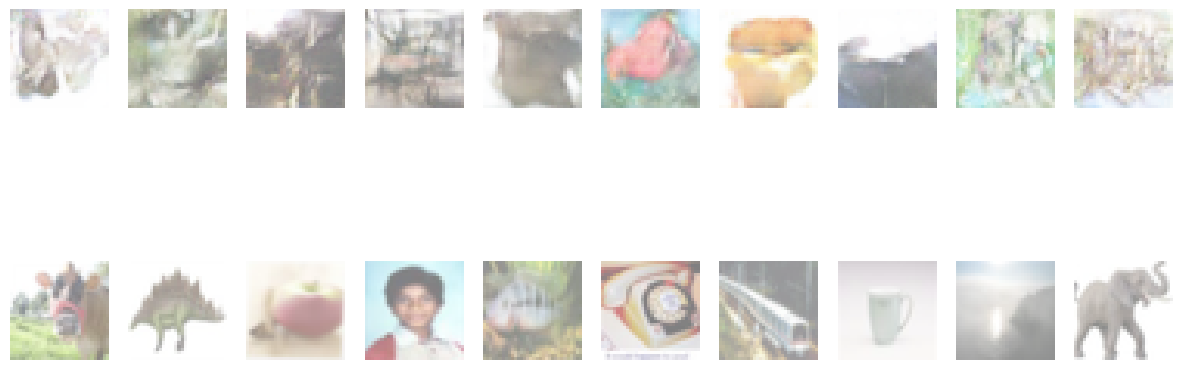

In [33]:
def visualize_samples(generated_samples, original_samples, num_samples):
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Зображення з генератора
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(np.transpose((generated_samples[i] + 1) / 2, (1, 2, 0)))
        plt.axis("off")

        # Оригінальне зображення
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(np.transpose((original_samples[i] + 1) / 2, (1, 2, 0)))
        plt.axis("off")

    plt.show()


original_samples = train_dataset[:num_samples][0]


visualize_samples(generated_samples.detach().cpu(), original_samples, num_samples)
